In [7]:
import sys
sys.path.append('/home/carol/repos/emg-regression')
print(sys.path)

['/home/carol/repos/emg-regression/examples', '', '/opt/ros/noetic/lib/python3/dist-packages', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '/home/carol/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/carol/repos/emg-regression', '/home/carol/repos/emg-regression']


In [15]:
#!/usr/bin/env python
import pickle
import torch
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from emg_regression.utils.data_processing import Data_processing
from emg_regression.utils.trainer import Trainer
from emg_regression.utils.model_tools import *
from emg_regression.approximators.lstm import LSTM


# 1. Normal LSTM

## 1.1. Training on dataset 1

### Load model

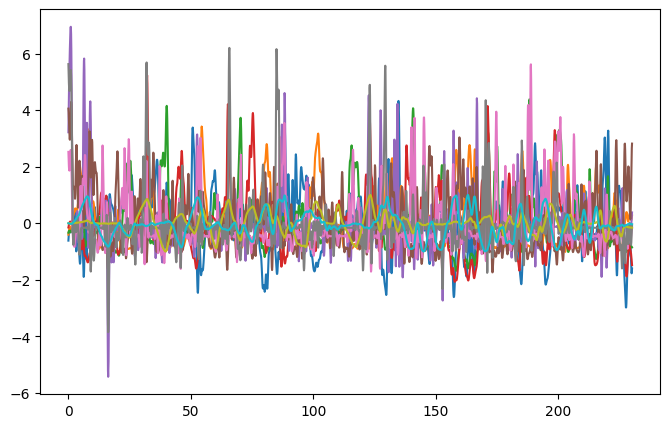

x.shape: (2295, 8) , y.shape: (2295, 2)


In [25]:
data_path = '../data/trunk_data/data_02_27.pkl'
data_ = pickle.load(open(data_path,'rb'))

data = Data_processing(data_,degrees=0,downsample_factor=1)
data.load_data()

features,target,time =data.get_emgfeatures(data.emgdata,data.desCmd,data.t)
features_filt = data.filter_features()

cut = -15
t = time[:cut]
x = data.features_filt[:cut,:] #TODO: try without filtering
y = target[:cut]
nb_features = x.shape[1]

x_mu, x_std = x.mean(0), x.std(0)
xn = (x-x_mu)/x_std

ymin, ymax = abs(y.min(0)), abs(y.max(0))
yn = np.where(y>=0,y/ymax,y/ymin)

x = xn
y = yn

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
# ax.plot(data.t_f,data.angles)
ax.plot(t,x)
# ax = fig.add_subplot(212)
ax.plot(t,y)
plt.show()

print('x.shape:',x.shape,', y.shape:',y.shape)

### Train model

In [26]:
# Train LSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dim_input, dim_output = np.shape(x)[1], np.shape(y)[1]
dim_hidden = 60
nb_layers = 2
dim_pre_output = 60
bidirectional = True

time_window = 1 # sec
window_size = int(time_window*data.fs_features)
offset = 1
print('window_size=',window_size)

#LSTM
approximator = LSTM(dim_input, dim_hidden, nb_layers,
                    dim_pre_output, dim_output, bidirectional).to(device)

train_x, test_x, train_y, test_y, t_train, t_test = split_train_test(x,y,train_ratio=0.75,t=t)

XTrain, YTrain, T_train = approximator.process_input(train_x, window_size, offset,
                                                     y=train_y, time=t_train)
# print(XTrain.shape, YTrain.shape, t_train.shape)
XTest, YTest, T_test = approximator.process_input(test_x, window_size, offset,
                                                     y=test_y, time=t_test)

nb_epochs = 500
mini_batch_size = 50 # or 30
learning_rate = 1e-2
weight_decay  = 1e-5
training_ratio = 0.9

# Train
trainer = Trainer(model=approximator, input=XTrain, target=YTrain)
trainer.options(normalize_input=False,
                normalize_output=False,
                epochs=nb_epochs,
                batch=mini_batch_size,
                shuffle=False,
                record_loss=True)

trainer.optimizer = torch.optim.Adam(approximator.parameters(),
                                     lr=learning_rate,
                                     weight_decay=weight_decay)

trainer.train()
trained_model = trainer.model

window_size= 10
EPOCH:  0  |  LOSS:  0.13919126822480132
EPOCH:  1  |  LOSS:  0.13817690137241567
EPOCH:  2  |  LOSS:  0.11219948971910136
EPOCH:  3  |  LOSS:  0.08453025328261511
EPOCH:  4  |  LOSS:  0.06838458882910865
EPOCH:  5  |  LOSS:  0.0730367127273764
EPOCH:  6  |  LOSS:  0.04631535621093852
EPOCH:  7  |  LOSS:  0.037317987464900525
EPOCH:  8  |  LOSS:  0.03145437767463071
EPOCH:  9  |  LOSS:  0.02794360269659332
EPOCH:  10  |  LOSS:  0.024642882363072462
EPOCH:  11  |  LOSS:  0.02346872179103749
EPOCH:  12  |  LOSS:  0.02143217358472092
EPOCH:  13  |  LOSS:  0.01690808864576476
EPOCH:  14  |  LOSS:  0.015671912939952952
EPOCH:  15  |  LOSS:  0.015063843902732644
EPOCH:  16  |  LOSS:  0.014246362394520215
EPOCH:  17  |  LOSS:  0.01340249572614474
EPOCH:  18  |  LOSS:  0.012814109938751374
EPOCH:  19  |  LOSS:  0.01215407894924283
EPOCH:  20  |  LOSS:  0.011512327017927808
EPOCH:  21  |  LOSS:  0.010769408562087588
EPOCH:  22  |  LOSS:  0.010181736773146051
EPOCH:  23  |  LOSS:

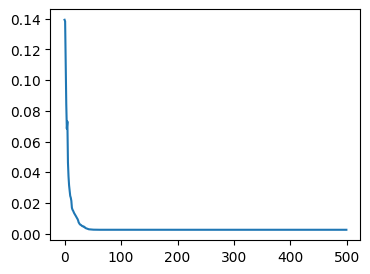

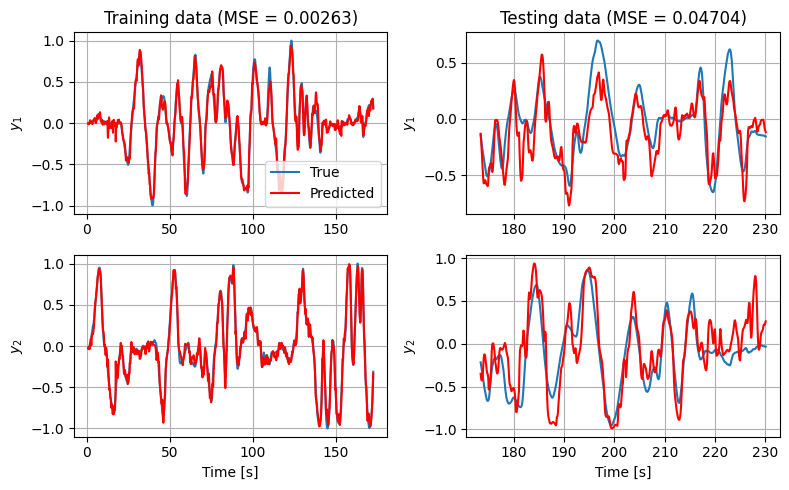

In [27]:
torch.cuda.empty_cache()
plt.subplots(figsize=(4,3))
plt.plot(trainer.losses)
plt.show()

mse_train, mse_test = evaluate_model(trained_model,
                                     XTrain=XTrain,YTrain=YTrain,
                                     XTest=XTest,YTest=YTest,
                                     t_train=T_train, t_test=T_test,
                                     vis=1)

# Save model and parameters
params = {"mu": train_x.mean(0), "std": train_x.std(0), "maxs":train_x.max(0),
            "window_size": window_size,
            "dim_input": dim_input, "dim_output": dim_output,
            "dim_pre_output": dim_hidden, "nb_layers": nb_layers,
            "bidirectional": bidirectional,
            "mini_batch_size": mini_batch_size, "learning_rate": learning_rate,
            "weight_decay": weight_decay, "nb_epochs": nb_epochs}

# save_model(path='data', model=trained_model, params=params)

### Test on dataset 2

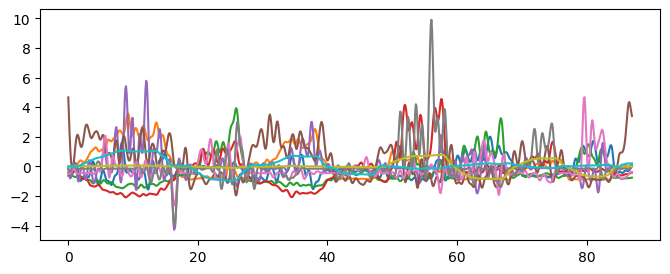

In [28]:
data_path = '../data/trunk_data/data_02_32.pkl'
data_ = pickle.load(open(data_path,'rb'))

data = Data_processing(data_,degrees=0,downsample_factor=1)
data.load_data()

features,target,time =data.get_emgfeatures(data.emgdata,data.desCmd,data.t)
features_filt = data.filter_features()

cut = -15
t = time[:cut]
x = data.features_filt[:cut,:]
y = target[:cut]
nb_features = x.shape[1]


#TODO: Change this to subtract by the mean and std of dataset 1, the one used to trian model.
# x_mu, x_std = x.mean(0), x.std(0)
xn = (x-x_mu)/x_std

# ymin, ymax = abs(y.min(0)), abs(y.max(0))
yn = np.where(y>=0,y/ymax,y/ymin)

x = xn
y = yn

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
# ax.plot(data.t_f,data.angles)
ax.plot(t,x)
# ax = fig.add_subplot(212)
ax.plot(t,y)
plt.show()

(859, 2) (859, 2) (859,)


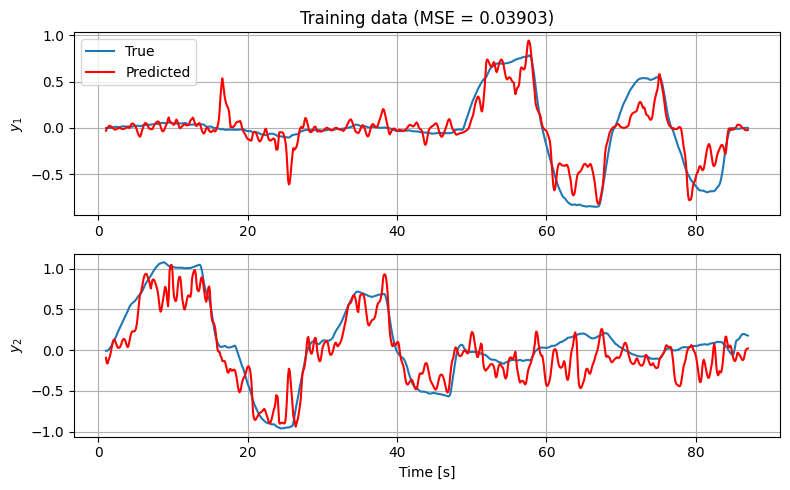

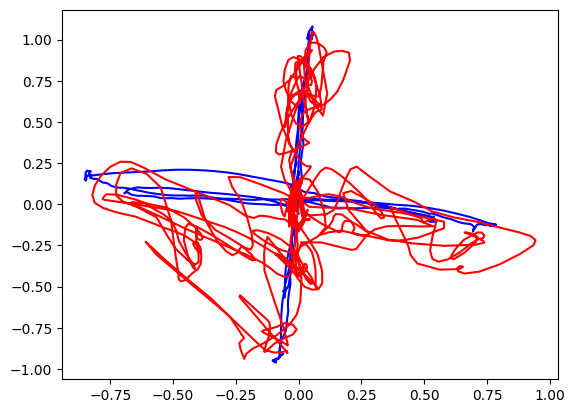

In [29]:
model = trained_model

# Unseen predictions on Training set
ytrain = y[window_size:,:]
x_tw = x[:window_size,:]
y_tw = y[:window_size,:]
ypred_k = y[window_size,:]
ypred = y_tw

for i in range(window_size,len(x)):
  # Get new emg window
  x_i = x[i,:]
  x_tw = np.vstack((x_tw,x_i))[-window_size:,:]
  X_tw = torch.from_numpy(x_tw).unsqueeze(0).float().to(device)

  # Get last predictions
  y_i = ypred_k
  y_tw = np.vstack((y_tw,y_i))[-window_size:,:]
  Y_tw = torch.from_numpy(y_tw).unsqueeze(0).float().to(device)

  # Make prediction
  ypred_k = model(X_tw).cpu().detach().numpy()
  ypred = np.vstack((ypred,ypred_k))

# ypred = ypred
ypred_train = ypred[window_size:,:]
t_train_ = t[window_size:]

print(ytrain.shape, ypred_train.shape, t_train_.shape)
mse_train, _ =  plot_regression(ytrain=ytrain, ytrain_pred=ypred_train, t_train=t_train_,
                                ytest=None, ytest_pred=None,t_test=None)


plt.subplots()
plt.plot(ytrain[:,0],ytrain[:,1],c='b',label='True')
plt.plot(ypred_train[:,0],ypred_train[:,1],c= 'r',label='Predicted')

## Explore types of filters:
###  help reduce noise and make the predictions more stable and reliable. 

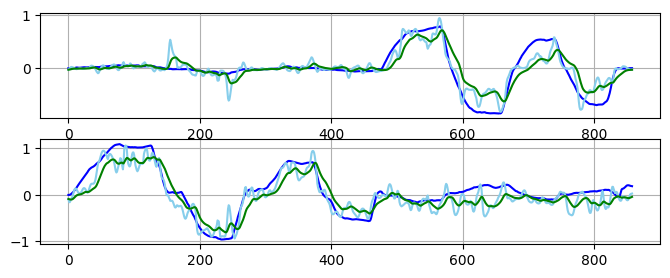

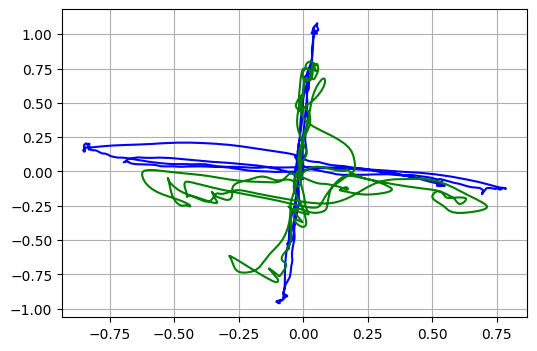

In [101]:
# More Smoothing: With  smaller alpha, the EMA places more weight on older data points 
# and less weight on most recent data points. This results in more smoothing of the 
# signal. The EMA becomes slower to react to sudden changes in the data, and it tends to 
# filter out short-term fluctuations or noise.

def EMA_filter(x,alpha):
    """ Exponential moving average filter """
    ema = np.array([x[0,:]])
    for i in range(1, len(x)):
        ema_value = alpha * x[i,:] + (1-alpha) * ema[i-1,:]
        ema = np.vstack((ema,ema_value))
    return ema

ypred_filt_EMA = EMA_filter(ypred_train,alpha=0.08)

fig,ax = plt.subplots(2,1,figsize=(8,3))
for i in range(2):
  ax[i].plot(ytrain[:,i],c='b',label='True')
  ax[i].plot(ypred_train[:,i],c='skyblue',label='Predicted')
  ax[i].plot(ypred_filt_EMA[:,i],linestyle='-',c='g',label='Predicted')
  ax[i].grid()

plt.subplots(figsize=(6,4))
plt.plot(ytrain[:,0],ytrain[:,1],c='b',label='True')
plt.plot(ypred_filt_EMA[:,0],ypred_filt_EMA[:,1],c= 'g',label='Predicted')
plt.grid()


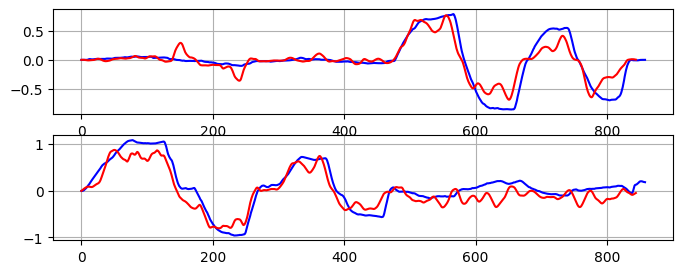

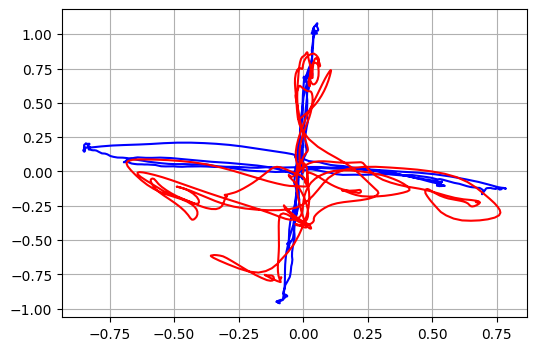

In [100]:
## Moving average filter
ypred_filt_MA = running_mean(ypred_train,15)

fig,ax = plt.subplots(2,1,figsize=(8,3))
for i in range(2):
  ax[i].plot(ytrain[:,i],c='b',label='True')
  ax[i].plot(ypred_filt_MA[:,i],c='r',label='Predicted')
  ax[i].grid()

plt.subplots(figsize=(6,4))
plt.plot(ytrain[:,0],ytrain[:,1],c='b',label='True')
plt.plot(ypred_filt_MA[:,0],ypred_filt_MA[:,1],c= 'r',label='Predicted')
plt.grid()